In [12]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [13]:
%cd ../gdrive/MyDrive/CSE_575/

[Errno 2] No such file or directory: '../gdrive/MyDrive/CSE_575/'
/gdrive/.shortcut-targets-by-id/1ZOjaaJR6FUgi-AiS0aWel7Gqn2TpkqgW/CSE_575


In [14]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, Activation 
from sklearn.metrics import classification_report as cr, confusion_matrix as cm

In [15]:
# Helper Functions
def load_data():
    ohe = OneHotEncoder(sparse_output=False)
    X = np.load("X.npy")[:,:,:,:3]
    y = np.load("y.npy")
    y = ohe.fit_transform(y.reshape(-1,1))
    labels = ohe.categories_[0]
    # X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)
    return X_train, X_val, X_test, y_train, y_val, y_test, labels

In [16]:
# Loading Data
X_train, X_val, X_test, y_train, y_val, y_test, labels = load_data()

In [17]:
# Model Definition
model_layers = [
    Conv2D(64, (3, 3), input_shape=(288, 432, 3)),
    MaxPool2D(pool_size=(3, 3)),

    Conv2D(32, (3, 3)),
    MaxPool2D(pool_size=(3, 3)),

    Conv2D(32, (3, 3)),
    MaxPool2D(pool_size=(3, 3)),

    Dropout(0.3),
    Flatten(),

    Dense(10, activation="softmax")
]

model = Sequential(model_layers)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 286, 430, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 95, 143, 64)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 93, 141, 32)       18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 45, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 15, 32)       

In [18]:
# Model Training
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=10, epochs=20)
print(f"Model Performance on Training Data: {model.evaluate(X_train,y_train)}")

Epoch 1/20
60/60 [==============================] - 6s 81ms/step - loss: 2.1912 - accuracy: 0.1987 - val_loss: 1.9623 - val_accuracy: 0.2550
Epoch 2/20
60/60 [==============================] - 4s 72ms/step - loss: 1.8211 - accuracy: 0.3689 - val_loss: 1.7974 - val_accuracy: 0.3700
Epoch 3/20
60/60 [==============================] - 4s 71ms/step - loss: 1.5340 - accuracy: 0.4574 - val_loss: 1.6060 - val_accuracy: 0.3900
Epoch 4/20
60/60 [==============================] - 4s 69ms/step - loss: 1.3353 - accuracy: 0.5242 - val_loss: 1.2964 - val_accuracy: 0.5600
Epoch 5/20
60/60 [==============================] - 5s 76ms/step - loss: 1.0635 - accuracy: 0.6444 - val_loss: 1.1549 - val_accuracy: 0.6100
Epoch 6/20
60/60 [==============================] - 4s 71ms/step - loss: 0.8927 - accuracy: 0.6728 - val_loss: 1.0420 - val_accuracy: 0.6500
Epoch 7/20
60/60 [==============================] - 4s 74ms/step - loss: 0.7787 - accuracy: 0.7462 - val_loss: 1.4181 - val_accuracy: 0.5800
Epoch 8/20
60

In [19]:
pred = model.predict(X_test)
pred = (pred>0.5)

print(cr(y_test,pred))
conf_m = cm(np.argmax(y_test,axis=1),np.argmax(pred,axis=1))
print(conf_m)

7/7 [==============================] - 0s 50ms/step
              precision    recall  f1-score   support

           0       0.65      0.42      0.51        26
           1       0.89      1.00      0.94        16
           2       0.50      0.36      0.42        11
           3       0.59      0.80      0.68        20
           4       1.00      0.63      0.77        27
           5       0.70      0.58      0.64        12
           6       0.73      0.76      0.74        21
           7       0.73      0.44      0.55        18
           8       0.47      0.58      0.52        24
           9       0.46      0.48      0.47        25

   micro avg       0.65      0.60      0.63       200
   macro avg       0.67      0.61      0.62       200
weighted avg       0.67      0.60      0.62       200
 samples avg       0.60      0.60      0.60       200

[[15  1  1  1  0  1  2  0  2  3]
 [ 0 16  0  0  0  0  0  0  0  0]
 [ 3  0  4  0  0  1  0  0  1  2]
 [ 1  0  0 16  0  0  0  0  2  1]
 [ 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


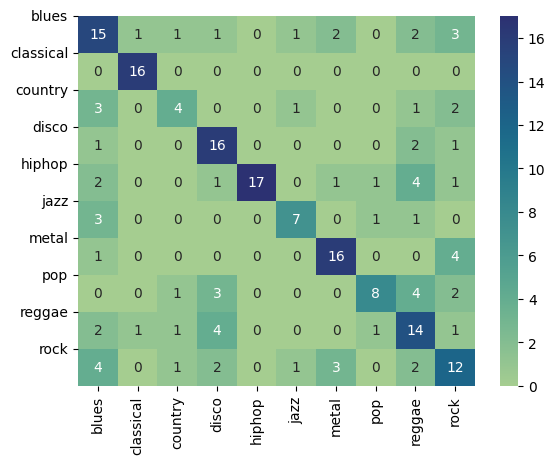

In [20]:
import seaborn as sns
from seaborn import heatmap
heatmap(conf_m,cmap="crest",annot=True)
plt.xticks(ticks = np.arange(0.5,10,1), labels=labels, rotation=90)
plt.yticks(ticks = np.arange(0,10,1), labels=labels,rotation=0)
plt.savefig('/content/CNN_Confusion_Matrix.png', dpi=300)

In [21]:
class_acc = conf_m.diagonal()/conf_m.sum(axis=1)
for i in range(len(labels)):
  print(f"Class Accuracy for {labels[i]}: {round(class_acc[i],2)}")
print(f"\n**Total Accuracy : {np.trace(conf_m)/np.sum(conf_m)}**")

Class Accuracy for blues: 0.58
Class Accuracy for classical: 1.0
Class Accuracy for country: 0.36
Class Accuracy for disco: 0.8
Class Accuracy for hiphop: 0.63
Class Accuracy for jazz: 0.58
Class Accuracy for metal: 0.76
Class Accuracy for pop: 0.44
Class Accuracy for reggae: 0.58
Class Accuracy for rock: 0.48

**Total Accuracy : 0.625**


In [22]:
model.save('/content/CNN.h5')